# Recover Current profiles from old Phase Diagram 

In [1]:
import sys
import os
sys.path.insert(0, '../magcolloids')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, clear_output
import scipy.optimize as spo
import scipy.spatial as spa 
import magcolloids as mgc
import matplotlib as mpl
import string as st
import itertools as it

from tqdm.auto import tqdm

ureg = mgc.ureg

idx = pd.IndexSlice

%reload_ext autoreload
%autoreload 2

In [2]:
mpl.rc('text', usetex=True)
mpl.rcParams['figure.dpi'] = 150

In [3]:
directory = "/media/Antonio/Dynamic/DimerCurrents/FrequencySweeps/FrequencySweep_3.9/"
index = pd.read_csv(os.path.join(directory, "index.dat"), 
                    sep=" ", names = ["file", "h", "tilt"])

In [4]:
index.head()

,file,h,tilt
0,Tilt_2.0_deg_h3899_2019_09_25_17_17_30,3.9,2.0
1,Tilt_16.5_deg_h3899_2019_09_25_17_17_30,3.9,16.5
2,Tilt_4.5_deg_h3899_2019_09_25_17_17_30,3.9,4.5
3,Tilt_1.5_deg_h3899_2019_09_25_17_17_30,3.9,1.5
4,Tilt_14.0_deg_h3899_2019_09_25_17_17_30,3.9,14.0


In [5]:
diff_vel_pd = pd.read_csv(os.path.join(directory,"differentiated_velocities_w_err.dat"),
            sep = "\t", 
            index_col = [0,1])

diff_vel_pd["tilt"] = index.reindex(diff_vel_pd.index.get_level_values("file")).tilt.values

diff_vel_pd = diff_vel_pd.set_index("tilt",append=True).reorder_levels(
    ["file","tilt","frequency"]).sort_index().droplevel(0)

diff_vel_pd.head()

x         y     x_err     y_err     x_std     y_std
tilt frequency                                                            
2.0  0.125     -0.057676 -0.137966  0.032227  0.028493  0.738416  0.652857
     0.250      0.162099  0.185934  0.061528  0.060820  1.411116  1.394880
     0.375      0.154448 -0.301165  0.091719  0.088772  2.105542  2.037888
     0.500      0.029361 -0.354682  0.120625  0.120483  2.769125  2.765855
     0.625      0.307811 -0.094988  0.151833  0.149104  3.482238  3.419650

In [6]:
d = 2.8
phi = 0.2625

factor = d*np.sqrt(np.pi/np.sqrt(3)/phi)

The factor of two below comes from the fact that each value of current only measures the current of the upper or lower plane. 

In [7]:
diff_vel_pd["I"] = 2*np.sqrt(
    (diff_vel_pd.x)**2 + 
    (diff_vel_pd.y)**2)/(factor*diff_vel_pd.index.get_level_values("frequency"))

diff_vel_pd["I_std"] = 2*np.sqrt(
    (diff_vel_pd.x_std)**2 + 
    (diff_vel_pd.y_std)**2)/(factor*diff_vel_pd.index.get_level_values("frequency"))

diff_vel_pd["I_err"] = 2*np.sqrt(
    (diff_vel_pd.x_err)**2 + 
    (diff_vel_pd.y_err)**2)/(factor*diff_vel_pd.index.get_level_values("frequency"))

frequencies = diff_vel_pd.index.get_level_values("frequency")
current = diff_vel_pd.I
current_err = diff_vel_pd.I_err
current_std = diff_vel_pd.I_std

## Plot of current vs $f$ for some tilts $\delta$ 

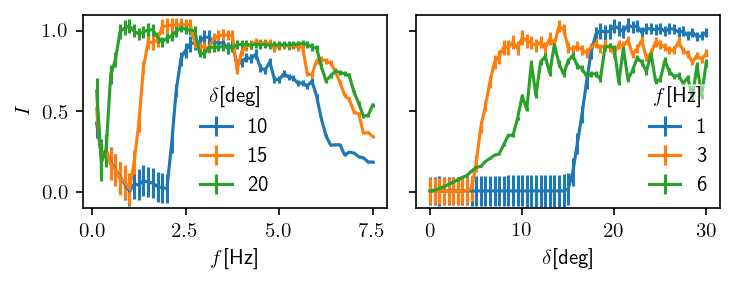

In [8]:
fig, ax = plt.subplots(1,2,figsize=(5,2), sharey=True, tight_layout=True)

for i in [10,15,20]:
    
    ax[0].errorbar(current.loc[i].index,
                   current.loc[i], current_err.loc[i],
                   label=i)


for f in [1,3,6]:
    ax[1].errorbar(current.reorder_levels(["frequency","tilt"]).sort_index().loc[f].index,
                   current.reorder_levels(["frequency","tilt"]).sort_index().loc[f],
                   current_err.reorder_levels(["frequency","tilt"]).sort_index().loc[f],
                   label = f)


ax[0].set_ylabel("$I$")
ax[0].set_xlabel("$f$[Hz]")
ax[1].set_xlabel("$\delta$[deg]")

ax[0].legend(
    title = "$\delta$[deg]",
    borderpad = 0.1,
    fancybox = False,
    edgecolor = "w",
    framealpha = 0.5,
    handlelength = 1.5,
    loc = 8
            )

ax[1].legend(
    title = "$f$[Hz]",
    borderpad = 0.1,
    fancybox = False,
    edgecolor = "w",
    framealpha = 0.5,
    handlelength = 1.5,
    loc = 4
            )

plt.ylim(-0.1,1.1)
plt.savefig("../Plots/current_vs_tilt_vs_freq.pdf")

In [9]:
current.loc[[10,15,20]].unstack().transpose().to_csv(
    "../Plots/current_vs_freq.dat", sep = "\t")
current.reorder_levels(["frequency","tilt"]
                      ).loc[[1,3,6]].unstack().transpose().to_csv(
    "../Plots/current_vs_tilt.dat", sep = "\t")